In [ ]:
!pip install tensorflow==1.14.0
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import distutils

In [ ]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2021-03-02 08:13:16--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.47.110
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.47.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  16.7MB/s    in 1.5s    

2021-03-02 08:13:18 (16.7 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2021-03-02 08:13:18--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.47.110
Connecting to fashion-mnist.s3-website.eu-central-1.amaz

In [ ]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/

In [ ]:
#Importing the MNIST Fashion DataSet.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [ ]:
#Training PArams
learning_rate = 0.0002
batch_size = 128
epochs = 100000

#Network params
image_dim = 784  #img sz is 28x28
gen_hidd_dim = 256
disc_hidd_dim  = 256
z_noise_dim = 100

#fuction to intialise weights

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev= 1./tf.sqrt(shape[0]/2.0))


In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
#initialising weights and bias for Discriminator and Generator Nueral Networks...(using Xavier initialisation)
weights = {
  "disc_H" : tf.Variable(xavier_init([image_dim,disc_hidd_dim])),
  "disc_final": tf.Variable(xavier_init([disc_hidd_dim,1])),
  "gen_H": tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
  "gen_final": tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
}

bias = {
    "disc_H" : tf.Variable(xavier_init([disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([1])),
    "gen_H": tf.Variable(xavier_init([gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([image_dim]))
}

In [ ]:
#Computational Graph
#defining the Discriminator 
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"]))
  disc_output = tf.nn.sigmoid(final_layer)
  return  disc_output

In [ ]:
# Defining the Generator NW
def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"]))
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output

In [ ]:
#define placeholders for external input

z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dim], name = "input_noise")
x_input = tf.placeholder(tf.float32, shape = [None, image_dim], name = "real_noise")

In [ ]:
#Building the Generator NW
with tf.name_scope("Generator") as scope:
  output_Gen = Generator(z_input) #G(z)
 
 # Building the Disc NW
with tf.name_scope("Discriminator") as scope:
   real_output_disc = Discriminator(x_input) #implements D(x)
   fake_output_disc = Discriminator(output_Gen) # implements D(G(x))

In [ ]:
#first loss

with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_disc+ 0.0001)+tf.log(1.- fake_output_disc+0.0001))
  # LF= log(D(x))+log(1-D(G(z)));
  
with tf.name_scope("Genetator_Loss") as scope:
  Generator_Loss = -tf.reduce_mean(tf.log(fake_output_disc+ 0.0001)) # due to max log(D(G(x)))
  #LF= log(1-D(G(z)))  -> -log(D(G(z)));
  # T-board summary
  
  Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
  Gen_loss_total = tf.summary.scalar("Gen_loss", Generator_Loss)

In [ ]:
#Making seperate dictionary for current weights and biases of Generator and Discriminator NW
Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

#Define the optimizer

with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Discriminator_Loss, var_list = Discriminator_var)

with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Generator_Loss, var_list = Generator_var)

In [ ]:
# Initialize the variables

init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  #dividing into batches
  x_batch, _ = mnist.train.next_batch(batch_size)
  
  #Generate noise to feed Discriminator
  z_noise = np.random.uniform(-1.,1.,size = [batch_size, z_noise_dim])
  #Discriminator
  _, Disc_loss_epoch = sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict = {x_input:x_batch, z_input:z_noise})
  #Generator
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict = {z_input:z_noise})  
  
  #Running the Discriminator summary
  summary_Disc_loss = sess.run(Disc_loss_total, feed_dict = {x_input:x_batch, z_input:z_noise})
  # Adding the Discriminator summary
  writer.add_summary(summary_Disc_loss, epoch)
  
  #Running the Generator summary
  summary_Gen_loss = sess.run(Gen_loss_total, feed_dict = {z_input:z_noise})
  # Adding the Generator summary
  writer.add_summary(summary_Gen_loss, epoch)
  
  if epoch % 2000 == 0:
    print("Steps: {0}: Generator Loss: {1}, Discriminator Loss:{2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))

Steps: 0: Generator Loss: 0.3168466091156006, Discriminator Loss:2.2208430767059326
Steps: 2000: Generator Loss: 2.814620018005371, Discriminator Loss:0.1660998910665512
Steps: 4000: Generator Loss: 2.618375778198242, Discriminator Loss:0.22142857313156128
Steps: 6000: Generator Loss: 2.689507484436035, Discriminator Loss:0.3522639870643616
Steps: 8000: Generator Loss: 2.5786824226379395, Discriminator Loss:0.3486100435256958
Steps: 10000: Generator Loss: 2.1681337356567383, Discriminator Loss:0.41044071316719055
Steps: 12000: Generator Loss: 2.2459638118743896, Discriminator Loss:0.6407985091209412
Steps: 14000: Generator Loss: 2.24898099899292, Discriminator Loss:0.6173733472824097
Steps: 16000: Generator Loss: 2.0087599754333496, Discriminator Loss:0.5716150999069214
Steps: 18000: Generator Loss: 2.7501749992370605, Discriminator Loss:0.5279225707054138
Steps: 20000: Generator Loss: 1.9858578443527222, Discriminator Loss:0.6344115734100342
Steps: 22000: Generator Loss: 2.30793452262

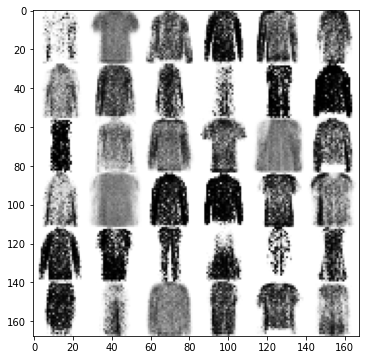

In [ ]:
#Testing
# Generate images from noise, using the generator network
import matplotlib.pyplot as plt
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  #Noise input
  z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  # Generate image from noise
  g = sess.run(output_Gen, feed_dict = {z_input:z_noise})
  # Reverse colors for better display
  g=-1*(g-1)
  for j in range(n):
    #Draw the generated images
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28, 28])
    
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()